In [1]:
urls = [
    "https://www.rhein-neckar-kreis.de/,Lde/start/landratsamt/coronavirus+fallzahlen+03-07.html",
    "https://www.rhein-neckar-kreis.de/,Lde/start/landratsamt/coronavirus+fallzahlen.html"
]

In [2]:
import urllib
import re

p = re.compile('a href="(.+?Faktenblatt_Corona_RNK\.pdf)" title="" target="_blank"><img alt="pdf')
pdf_urls = []
for url in urls:
    with urllib.request.urlopen(url) as f:
        t = f.read().decode("utf-8")
        pdf_urls += list(p.findall(t))

In [3]:
import os

url_root = "https://www.rhein-neckar-kreis.de/"
for pdf_url in pdf_urls:
    pdf_fn = pdf_url.split('/')[-1]
    if os.path.exists(pdf_fn):
        continue
    print("Downloading %s..."%pdf_fn)
    with urllib.request.urlopen(url_root + pdf_url) as f, open(pdf_fn, "wb") as fo:
        fo.write(f.read())

In [5]:
    import numpy as np
    from glob import glob

    pdf_fns = sorted(glob("*RNK.pdf"))
    covid_numbers = np.zeros([2, 3], dtype=int)
    from PyPDF4.pdf import PdfFileReader
    with open("rnk_stats.tsv", "w") as f1, open("heidelberg_stats.tsv", "w") as f2:
        headers = "Date\tTotal\tRecovered\tDeaths\tCurrent\n"
        f1.write(headers)
        f2.write(headers)
        for pdf_fn in pdf_fns:
            date = "20%s-%s-%s"%(pdf_fn[:2], pdf_fn[2:4], pdf_fn[4:6])
            r = PdfFileReader(pdf_fn)
            entries = r.getPage(0).extractText().split('\n')
            flags = np.zeros(3, dtype=bool)
            for idx, e in enumerate(entries):
                if not flags[0] and ("Positive" in e or "Gesamtzahl" in e):
                    covid_numbers[:, 0] = [int(e.strip()) for e in entries[idx+1:idx+3]]
                    flags[0] = True
                if not flags[1] and "Genesene" in e:
                    if 'Datenbank-Fehlers' in entries[-4] and 'Genesene Personen' in entries[-4]:
                        covid_numbers[:, 1] = recovered_yesterday
                    else:
                        covid_numbers[:, 1] = [int(e.strip('*').strip()) for e in entries[idx+1:idx+3]]
                        recovered_yesterday = np.array(covid_numbers[:, 1], copy=True)
                    flags[1] = True
                if not flags[2] and "Verstorbene" in e:
                    covid_numbers[:, 2] = [int(e.strip()) for e in entries[idx+1:idx+3]]
                    flags[2] = True
            f1.write(date); f2.write(date)
            for i in range(2):
                n_current = str(covid_numbers[i, :][0] - covid_numbers[i, :][1] - covid_numbers[i, :][2])
                if i == 0:
                    f = f1
                else:
                    f = f2
                f.write('\t' + '\t'.join([str(e) for e in covid_numbers[i, :]] + [n_current, ]))
            f1.write('\n'); f2.write('\n')

<AxesSubplot:title={'center':'COVID-19 stats Heidelberg'}, xlabel='Date'>

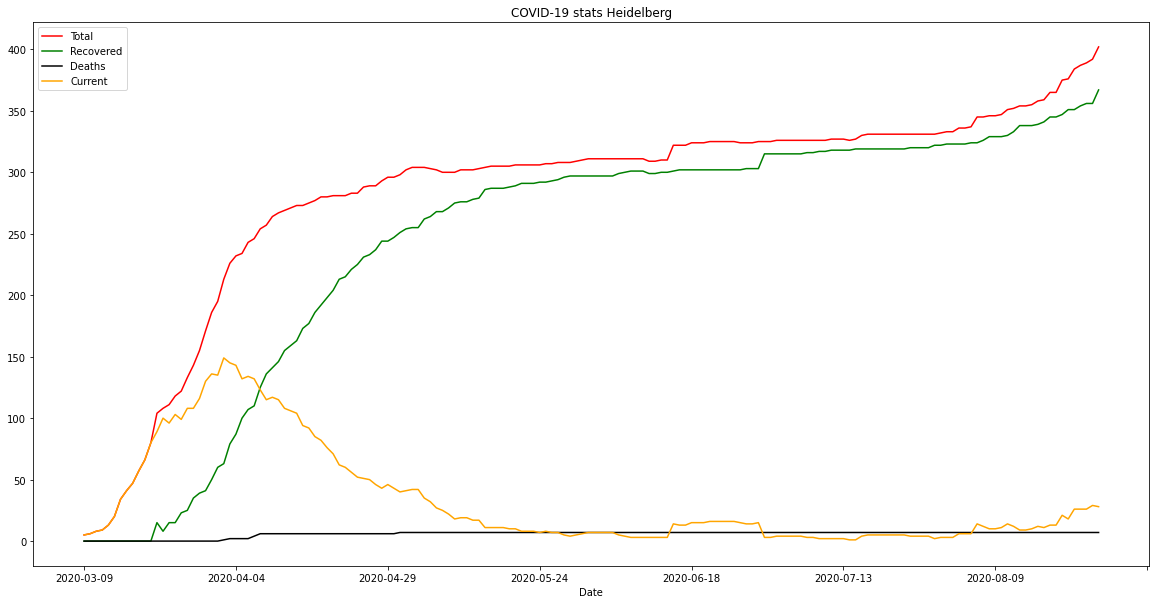

In [10]:
import pandas as pd
df = pd.read_csv("heidelberg_stats.tsv", sep='\t')
df.set_index('Date').plot(figsize=[20, 10], color=['red', 'green', 'black', 'orange'], title="COVID-19 stats Heidelberg")

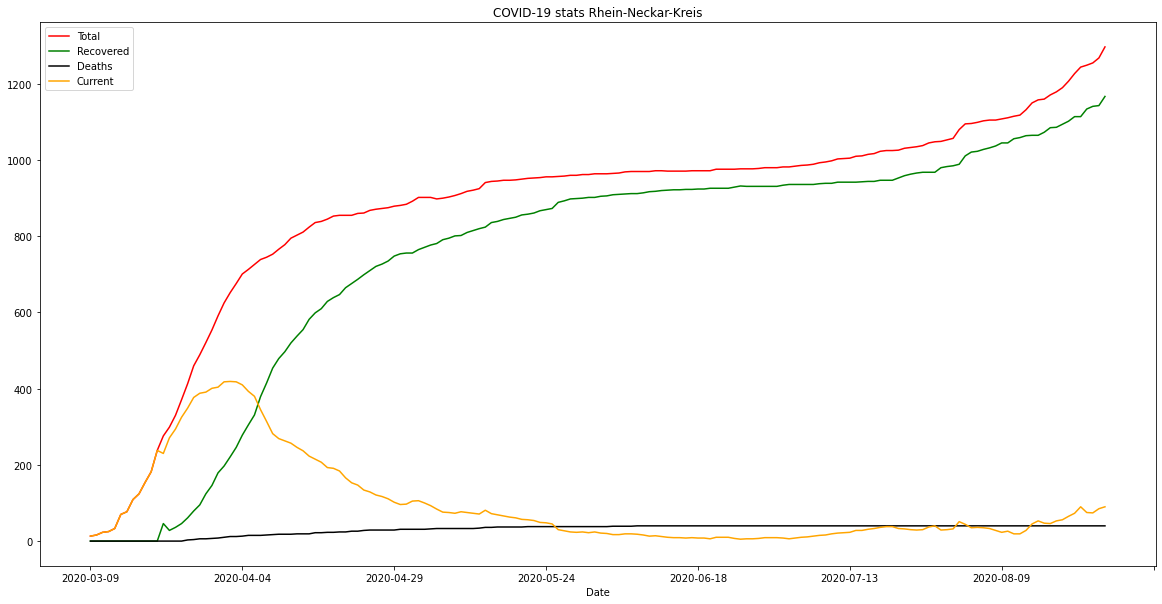

In [12]:
import pandas as pd
df = pd.read_csv("rnk_stats.tsv", sep='\t')
ax = df.set_index('Date').plot(figsize=[20, 10], color=['red', 'green', 'black', 'orange'], title="COVID-19 stats Rhein-Neckar-Kreis")
ax.figure.savefig()